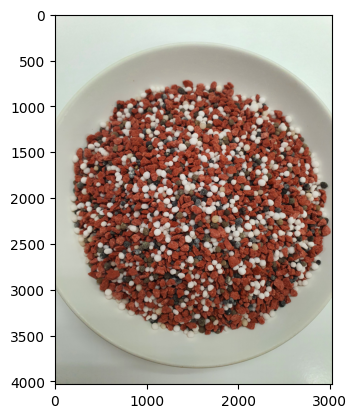

In [5]:
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
import torch
import os
import matplotlib.pyplot as plt

# === Load the image ===
folder_path_1 = "pictures/14-7-35"
folder_path_2 = "pictures/15-7-18"
folder_path_3 = "pictures/15-15-15"
folder_path_4 = "pictures/18-4-5"
images_path_1 = [os.path.join(folder_path_1, f) for f in os.listdir(folder_path_1) if f.endswith('.jpg')]
images_path_2 = [os.path.join(folder_path_2, f) for f in os.listdir(folder_path_2) if f.endswith('.jpg')]
images_path_3 = [os.path.join(folder_path_3, f) for f in os.listdir(folder_path_3) if f.endswith('.jpg')]
images_path_4 = [os.path.join(folder_path_4, f) for f in os.listdir(folder_path_4) if f.endswith('.jpg')]

# Optional: visualize the image (for debugging)
image_bgr = cv2.imread(images_path_1[0])  # Load the first image from the first folder
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()


Image dimensions: 4032x3024


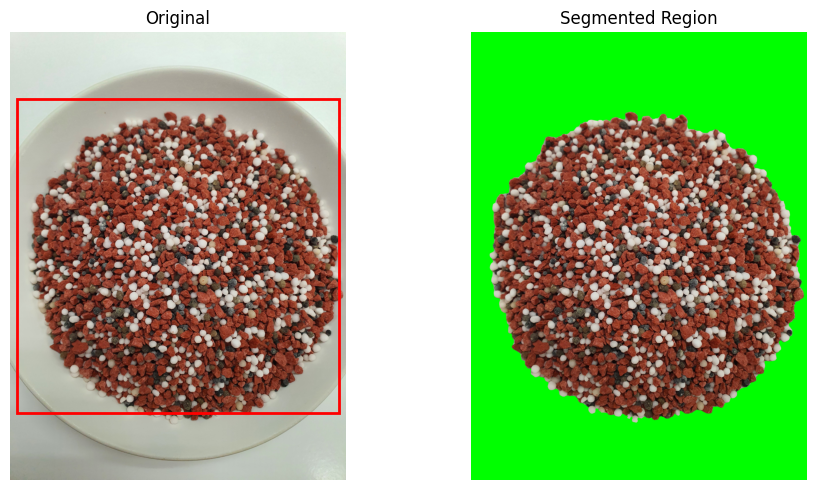

In [6]:
import torch
from segment_anything import sam_model_registry, SamPredictor

# === Load the SAM model ===
sam_checkpoint = "sam_vit_b_01ec64.pth"  # Path to your checkpoint file
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# === Load and prepare the image ===
image_bgr = cv2.imread(images_path_1[0])  # Change to your image path
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)

# === Define a bounding box ===
# Format: [x0, y0, x1, y1] (top-left to bottom-right)
H, W = image_rgb.shape[:2]
print(f"Image dimensions: {H}x{W}")
min_h =  int(H * 0.15)  # Minimum height for the box
max_h = int(H * 0.85)   # Maximum height for the box
min_w = int(W * 0.02)   # Minimum width for the box
max_w = int(W * 0.98)   # Maximum width for the box
input_box = np.array([min_w, min_h, max_w, max_h])  # ← Change as needed

# === Segment using the box ===
masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=False  # Only return the most confident mask
)

# === Visualize ===
mask = masks[0]

# Overlay the mask
masked_image = image_rgb.copy()
masked_image[~mask] = [0, 255, 0]  # Set everything else to black

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original")
plt.gca().add_patch(plt.Rectangle(
    (input_box[0], input_box[1]),
    input_box[2] - input_box[0],
    input_box[3] - input_box[1],
    edgecolor='red',
    linewidth=2,
    facecolor='none'
))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title("Segmented Region")
plt.axis('off')

plt.tight_layout()
plt.show()


Start: Getting image shape and flattening pixels...
Filtering out pure green pixels...
Running KMeans clustering into 4 clusters...
Preparing valid indices for mapping back...
Processing each cluster to create masks and points...


Clusters:  25%|██▌       | 1/4 [00:01<00:04,  1.45s/it]

Cluster 0: mask created with 1532767 points.


Clusters:  50%|█████     | 2/4 [00:03<00:03,  1.55s/it]

Cluster 1: mask created with 1091019 points.


Clusters:  75%|███████▌  | 3/4 [00:04<00:01,  1.30s/it]

Cluster 2: mask created with 817401 points.


Clusters: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]

Cluster 3: mask created with 2589031 points.
All clusters processed. Starting visualization...


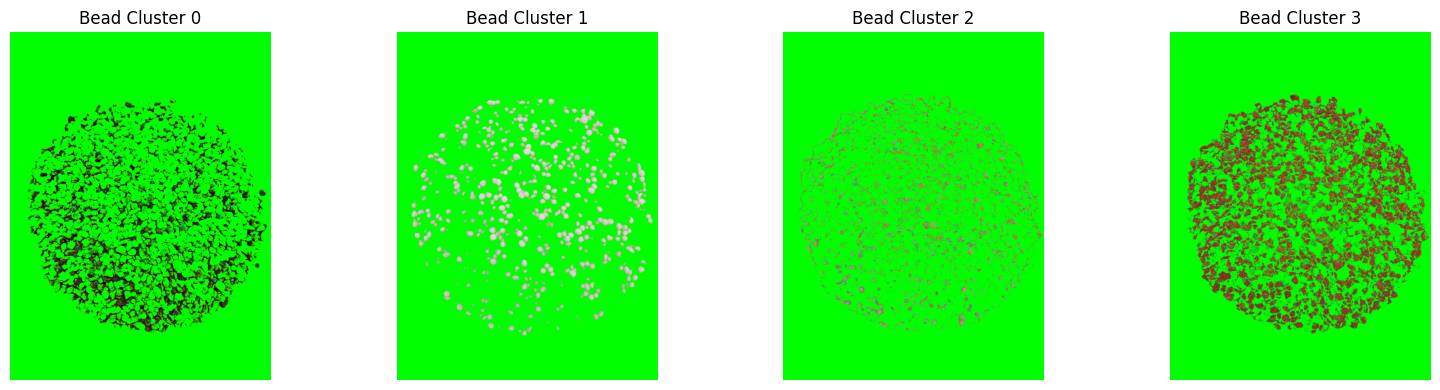

In [7]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # <-- added tqdm import

BEAD_MASKS = 4  # Number of masks to create

def get_all_grouped_points(label):
    point_coords = []
    
    group_indices = np.where(labels == label)[0]  # Get indices of pixels in the current group
    for indice in group_indices:
        original_flat_index = valid_indices[indice]
        y, x = divmod(original_flat_index, W)
        point_coords.append([x, y])  # x = col, y = row

    point_coords = np.array(point_coords)

    return point_coords


print("Start: Getting image shape and flattening pixels...")
H, W, _ = masked_image.shape
pixels = masked_image.reshape(-1, 3)

print("Filtering out pure green pixels...")
non_black_indices = np.any(pixels != [0, 255, 0], axis=1)
pixels_non_black = pixels[non_black_indices]

print("Running KMeans clustering into", BEAD_MASKS, "clusters...")
kmeans = KMeans(n_clusters=BEAD_MASKS, random_state=42)
labels = kmeans.fit_predict(pixels_non_black)

print("Preparing valid indices for mapping back...")
valid_indices = np.where(non_black_indices)[0]

all_masks = []
all_point_coords = []

print("Processing each cluster to create masks and points...")
for cluster_label in tqdm(range(BEAD_MASKS), desc="Clusters"):
    mask_flat = np.zeros(H*W, dtype=bool)
    cluster_pixel_indices = valid_indices[labels == cluster_label]
    mask_flat[cluster_pixel_indices] = True
    mask_2d = mask_flat.reshape(H, W)
    point_coords = get_all_grouped_points(cluster_label)
    all_masks.append(mask_2d)
    all_point_coords.append(point_coords)
    print(f"Cluster {cluster_label}: mask created with {len(point_coords)} points.")

print("All clusters processed. Starting visualization...")

# New visualization: full cluster images with colored pixels, no dots
plt.figure(figsize=(16, 4))
for i in range(BEAD_MASKS):
    cluster_img = np.full_like(image_rgb, fill_value=[0, 255, 0])  # Green background
    mask = all_masks[i]
    cluster_img[mask] = image_rgb[mask]  # Paste cluster's original colors on top
    
    plt.subplot(1, BEAD_MASKS, i + 1)
    plt.imshow(cluster_img)
    plt.title(f"Bead Cluster {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Running KMeans...
Counting beads with SAM...


Clusters: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


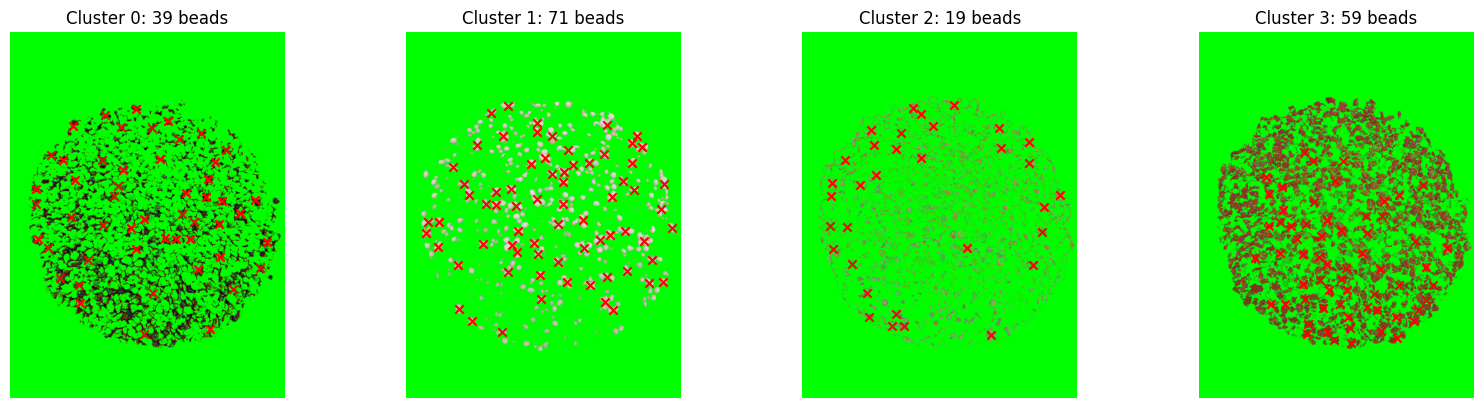


Summary:
Cluster 0: 39 beads
Cluster 1: 71 beads
Cluster 2: 19 beads
Cluster 3: 59 beads
Total: 188


In [11]:
from sklearn.cluster import KMeans
from segment_anything import SamPredictor, sam_model_registry
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from tqdm import tqdm

# === Config ===
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
BEAD_MASKS = 4

# === Initialize SAM ===
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

# === Preprocess image ===
H, W, _ = masked_image.shape
pixels = masked_image.reshape(-1, 3)
non_green = np.any(pixels != [0, 255, 0], axis=1)
valid_indices = np.where(non_green)[0]
pixels_non_green = pixels[non_green]

# === KMeans clustering ===
print("Running KMeans...")
kmeans = KMeans(n_clusters=BEAD_MASKS, random_state=42)
labels = kmeans.fit_predict(pixels_non_green)

# === Create color cluster masks ===
all_masks = []
for i in range(BEAD_MASKS):
    mask_flat = np.zeros(H * W, dtype=bool)
    cluster_pixels = valid_indices[labels == i]
    mask_flat[cluster_pixels] = True
    all_masks.append(mask_flat.reshape(H, W))

# === Function to detect bead centers using contours ===
def get_centers(mask, min_area=4000, min_dist=100):
    centers = []
    mask_uint8 = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                if all(np.hypot(cx - x, cy - y) > min_dist for x, y in centers):
                    centers.append((cx, cy))
    return centers

# === Count beads with SAM ===
print("Counting beads with SAM...")
all_counts, all_centers = [], []
predictor.set_image(image_rgb)

for i, mask in enumerate(tqdm(all_masks, desc="Clusters")):
    centers = get_centers(mask)
    count = 0
    for x, y in centers:
        try:
            masks, scores, _ = predictor.predict(
                point_coords=np.array([[x, y]]),
                point_labels=np.array([1]),
                multimask_output=True
            )
            best_mask = masks[np.argmax(scores)]
            # Adjust the value below based on output quality
            if np.sum(best_mask) > 80 and np.sum(mask & best_mask) / np.sum(best_mask) > 0.2:
                count += 1
        except:
            continue
    all_counts.append(count)
    all_centers.append(centers)

# === Visualization ===
plt.figure(figsize=(16, 8))
for i, (mask, centers) in enumerate(zip(all_masks, all_centers)):
    cluster_img = np.full_like(image_rgb, [0, 255, 0])
    cluster_img[mask] = image_rgb[mask]
    plt.subplot(2, BEAD_MASKS, i + 1)
    plt.imshow(cluster_img)
    if centers:
        cx, cy = zip(*centers)
        plt.scatter(cx, cy, c='red', marker='x')
    plt.title(f"Cluster {i}: {all_counts[i]} beads")
    plt.axis('off')
plt.tight_layout()
plt.show()

# === Summary ===
print("\nSummary:")
for i, c in enumerate(all_counts):
    print(f"Cluster {i}: {c} beads")
print("Total:", sum(all_counts))
